# Коэффициент восстановления золота из золотосодержащей руды

Требуется построить модель машинного обучения для предсказания коэффициента восстановления золота из руды. 

Данные нужно будет подготовить, проверить на наличие аномалий.
Качество модели нужно будет оценить с помощью sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»). Итоговое sMAPE складывается из оценок концентрации после флотации и финальной концентрации золота после очисток.

Использовались следующие модели: LinearRegression, DecisionTreeRegressor, RandomForestRegressor. Оптимальные параметры находились с помощью кросс-валидации.

### План работы
1. [Подготовка данных](#1.-Подготовка-данных)
2. [Анализ данных](#2.-Анализ-данных)
3. [Обучение и тестирование модели](#3.-Модель)
4. [Общий вывод](#4.-Общий-вывод)


### Описание данных  
Данные с параметрами 3ех этапов процесса восстановления золота и финальные значения. Целевой признак: концентрация золота после первого этапа (флотации) и финальная концентрация золота после очистки.

# 1. Подготовка данных

In [1]:
#импортирование нужных библиотек:
import pandas as pd
import numpy as np
from numpy.random import RandomState
state = RandomState(12345) 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

#визуализация
import matplotlib.pyplot as plt
import seaborn as sns

#игнорирование предупреждений
import warnings
warnings.filterwarnings("ignore")

In [2]:
full = pd.read_csv('datasets/gold_recovery_full.csv', index_col='date', parse_dates=True) 
train = pd.read_csv('datasets/gold_recovery_train.csv', index_col='date', parse_dates=True)
test = pd.read_csv('datasets/gold_recovery_test.csv', index_col='date', parse_dates=True)

display(full.shape)
display(train.shape)
display(test.shape)

(22716, 86)

(16860, 86)

(5856, 52)

In [3]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name 

In [4]:
full.name = get_df_name(full)
train.name = get_df_name(train)
test.name = get_df_name(test)

In [5]:
def examine_df(df):
    print(f'Данные {df.name}')
    display(df.head(10))
    display(df.info())
    display(df.describe())
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.style.format('{:.1f}', subset='Percent')
    
    print(f'Количество пропусков {missing_data}')    
    print(f'Количество дубликатов : {df.duplicated().sum()}')
    print('_____________________________________________')

In [6]:
display(examine_df(full))    
display(examine_df(train))
display(examine_df(test))

Данные full


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,115.581252,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,117.322323,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,124.592960,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,131.781026,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float64
primary_c

None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


Количество пропусков                                                Total    Percent
rougher.output.recovery                         3119  13.730410
rougher.output.tail_ag                          2737  12.048776
rougher.output.tail_sol                         2736  12.044374
rougher.output.tail_au                          2736  12.044374
rougher.input.floatbank11_xanthate              2257   9.935728
...                                              ...        ...
rougher.calculation.sulfate_to_au_concentrate     44   0.193696
primary_cleaner.state.floatbank8_d_level          43   0.189294
primary_cleaner.state.floatbank8_b_level          43   0.189294
primary_cleaner.state.floatbank8_c_level          43   0.189294
primary_cleaner.input.feed_size                    0   0.000000

[86 rows x 2 columns]
Количество дубликатов : 22
_____________________________________________


None

Данные train


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,115.581252,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,117.322323,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,124.592960,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,131.781026,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_c

None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


Количество пропусков                                                     Total    Percent
rougher.output.recovery                              2573  15.260973
rougher.output.tail_ag                               2250  13.345196
rougher.output.tail_sol                              2249  13.339265
rougher.output.tail_au                               2249  13.339265
secondary_cleaner.output.tail_sol                    1986  11.779359
...                                                   ...        ...
rougher.calculation.floatbank10_sulfate_to_au_feed     27   0.160142
rougher.calculation.sulfate_to_au_concentrate          27   0.160142
primary_cleaner.state.floatbank8_d_level               27   0.160142
primary_cleaner.state.floatbank8_c_level               27   0.160142
primary_cleaner.input.feed_size                         0   0.000000

[86 rows x 2 columns]
Количество дубликатов : 16
_____________________________________________


None

Данные test


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,-497.903666,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,-497.923683,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,-503.451306,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,-499.890350,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                    

None

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


Количество пропусков                                             Total   Percent
rougher.input.floatbank11_xanthate            353  6.028005
primary_cleaner.input.sulfate                 302  5.157104
primary_cleaner.input.depressant              284  4.849727
rougher.input.floatbank10_sulfate             257  4.388661
primary_cleaner.input.xanthate                166  2.834699
rougher.input.floatbank10_xanthate            123  2.100410
rougher.input.feed_sol                         67  1.144126
rougher.input.floatbank11_sulfate              55  0.939208
rougher.input.feed_rate                        40  0.683060
secondary_cleaner.state.floatbank3_a_air       34  0.580601
secondary_cleaner.state.floatbank2_b_air       23  0.392760
rougher.input.feed_size                        22  0.375683
secondary_cleaner.state.floatbank2_a_air       20  0.341530
rougher.state.floatbank10_a_air                17  0.290301
rougher.state.floatbank10_d_air                17  0.290301
rougher.state.float

None

Избавимся от дубликатов в обучающей и тестовой выборках:

In [7]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

Данные с пропусками в столбцах с результатами (все, что содержат "output" в названии) не помогут при обучении модели, избавимся от них:

In [8]:
output_columns = train.columns[train.columns.str.contains('final.output', na=False) | train.columns.str.contains('rougher.output', na=False)]
train.dropna(subset=list(output_columns), inplace = True)

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между расчётами и значением признака. 

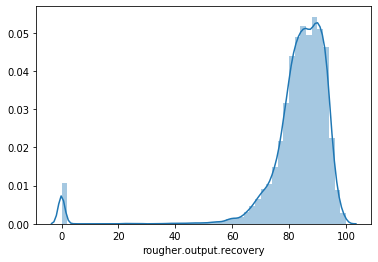

In [9]:
sns.distplot(train['rougher.output.recovery'])

In [10]:
output_calculated = train['rougher.output.concentrate_au'] * (train['rougher.input.feed_au'] - train['rougher.output.tail_au']) / (train['rougher.input.feed_au'] * (train['rougher.output.concentrate_au'] - train['rougher.output.tail_au'])) * 100

display(mean_absolute_error(train['rougher.output.recovery'], output_calculated))

9.483936877516321e-15

MAE между значениями rougher.output.recovery и расчетами практически равна нулю, что означает, что этот признак был правильно рассчитан (по крайней мере в обучающей выборке)

Проанализируем признаки, недоступные в тестовой выборке:

In [11]:
display(train.columns.difference(test.columns))

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

В тестовой выборке нет признаков с результатами и вычислениями, их, видимо проводят уже после окончания процесса.

В условиях сказано, что "Соседние по времени параметры часто похожи.", поэтому можем заменить пропуски в датасетах методом forward fill.

In [12]:
train.fillna(method='ffill', inplace=True)
full.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

# 2. Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки  



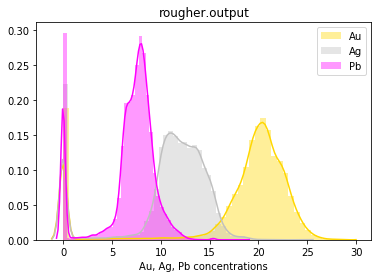

In [18]:
sns.distplot(full['rougher.output.concentrate_au'], color = 'gold', label='Au').set_title('rougher.output')
sns.distplot(full['rougher.output.concentrate_ag'], color = 'silver', label='Ag')
sns.distplot(full['rougher.output.concentrate_pb'], color = 'magenta', label='Pb').set_xlabel('Au, Ag, Pb concentrations')

plt.legend()

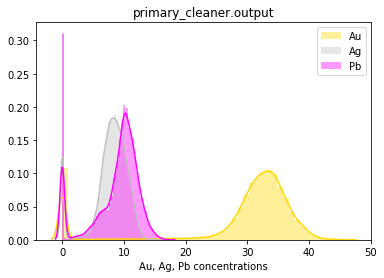

In [19]:
sns.distplot(full['primary_cleaner.output.concentrate_au'], color = 'gold', label='Au').set_title('primary_cleaner.output')
sns.distplot(full['primary_cleaner.output.concentrate_ag'], color = 'silver', label='Ag')
sns.distplot(full['primary_cleaner.output.concentrate_pb'], color = 'magenta', label='Pb').set_xlabel('Au, Ag, Pb concentrations')
plt.legend()

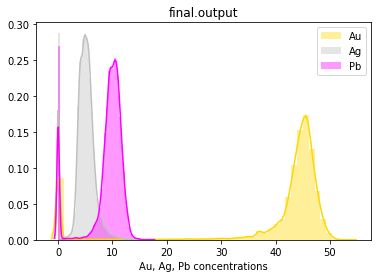

In [17]:
sns.distplot(full['final.output.concentrate_au'], color = 'gold', label='Au').set_title('final.output')
sns.distplot(full['final.output.concentrate_ag'], color = 'silver', label='Ag')
sns.distplot(full['final.output.concentrate_pb'], color = 'magenta', label='Pb').set_xlabel('Au, Ag, Pb concentrations')
plt.legend()

В процессе очистки доля золота увеличивается в сравнении с другими металлами, что логично, это и есть цель всего процесса.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

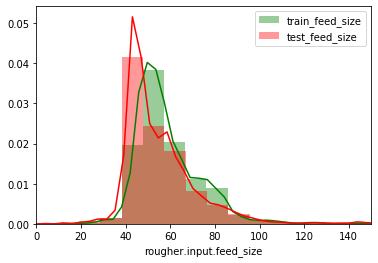

In [20]:
sns.distplot(train['rougher.input.feed_size'], color = 'green', label='train_feed_size').set_xlim(0,150)
sns.distplot(test['rougher.input.feed_size'], color = 'red', label='test_feed_size')
plt.legend()


In [17]:
display(train['rougher.input.feed_size'].describe())
display(test['rougher.input.feed_size'].describe())

count    13809.000000
mean        60.307603
std         23.194610
min          9.659576
25%         48.964787
50%         55.211916
75%         66.059863
max        484.967466
Name: rougher.input.feed_size, dtype: float64

count    5850.000000
mean       55.912336
std        22.715715
min         0.046369
25%        43.866282
50%        49.983653
75%        61.634721
max       477.445473
Name: rougher.input.feed_size, dtype: float64

Средние значения размеров гранул в обучающей и тестовой выборках отличаются несильно и их распределения похожи.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Есть ли аномальные значения в суммарном распределении или нет? 

Text(0.5, 1.0, 'суммарная концентрация веществ rougher.output')

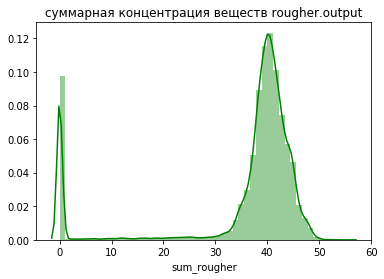

In [18]:
full['sum_rougher'] = full['rougher.output.concentrate_au'] + full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb']
sns.distplot(full['sum_rougher'], color = 'green').set_title('суммарная концентрация веществ rougher.output')#.set_xlabel('суммарная концентрация веществ')

Text(0.5, 1.0, 'суммарная концентрация веществ primary_cleaner.output')

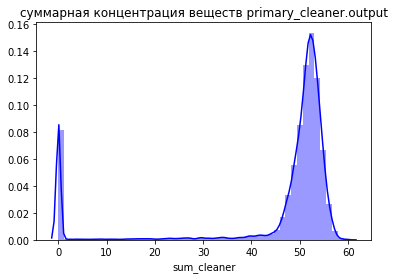

In [19]:
full['sum_cleaner'] = full['primary_cleaner.output.concentrate_au'] + full['primary_cleaner.output.concentrate_ag'] + full['primary_cleaner.output.concentrate_pb']
sns.distplot(full['sum_cleaner'], color = 'blue').set_title('суммарная концентрация веществ primary_cleaner.output')

Text(0.5, 1.0, 'суммарная концентрация веществ final.output')

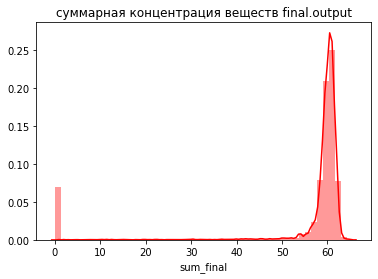

In [20]:
full['sum_final'] = full['final.output.concentrate_au'] + full['final.output.concentrate_ag'] + full['final.output.concentrate_pb']
sns.distplot(full['sum_final'], color = 'red').set_title('суммарная концентрация веществ final.output')

Существуют записи с нулевыми суммарными концентрациями веществ, они нам не помогут при обучении модели, удалим их из всех выборок.

In [21]:
def delete_zeros(column):
    sum_zeros = full[column] == 0
    a = train.index.intersection(full[sum_zeros].index)
    train.drop(a, axis=0, inplace=True)

    b = test.index.intersection(full[sum_zeros].index)
    test.drop(b, axis=0, inplace=True)

In [22]:
delete_zeros('sum_final')
delete_zeros('sum_cleaner')
delete_zeros('sum_rougher')

# 3. Модель

Обучим разные модели и проверим их качетство с помощью sMAPE:

In [23]:
def total_sMAPE(target, predictions):
    smape_rougher = 0
    smape_final = 0
    for i in range(len(target)):
        target_rougher = target[i, 0]
        predictions_rougher = predictions[i, 0]
        target_final = target[i, 1]
        predictions_final = predictions[i, 1]
        sum_abs_rougher = (abs(target_rougher) + abs(predictions_rougher))/2
        sum_abs_final = (abs(target_final) + abs(predictions_final))/2
        diff_abs_rougher = abs(target_rougher - predictions_rougher)
        diff_abs_final = abs(target_final - predictions_final)
        smape_rougher += diff_abs_rougher / sum_abs_rougher
        smape_final += diff_abs_final / sum_abs_final
    smape_rougher = smape_rougher * 100 / len(target)
    smape_final = smape_final * 100 / len(target)
    total_smape = 0.25 * smape_rougher + 0.75 * smape_final
    return total_smape



In [24]:
target_train = train[['rougher.output.recovery', 'final.output.recovery']].to_numpy()
features_train = train.drop(train.columns.difference(test.columns), axis=1)
target_test = full.loc[test.index, ['rougher.output.recovery', 'final.output.recovery']].to_numpy()

In [25]:
display(target_train.shape)
display(features_train.shape)
display(test.shape)
display(target_test.shape)

(13393, 2)

(13393, 52)

(5270, 52)

(5270, 2)

In [26]:
scaler = StandardScaler()
scaler.fit(features_train.loc[:,:])
features_train.loc[:,:] = scaler.transform(features_train.loc[:,:])
test.loc[:,:] = scaler.transform(test.loc[:,:])

In [27]:
scoring = make_scorer(total_sMAPE)

In [28]:
models = [LinearRegression(), DecisionTreeRegressor(random_state=state), RandomForestRegressor(random_state=state)]


In [29]:
for model in models:
    score = cross_val_score(model, features_train, target_train, cv=5, scoring=scoring)
    print(model, '\n', score)
    print('Итоговая оценка', score.mean())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 
 [10.88763857  8.55206479  8.25015295  7.93789409 11.64362562]
Итоговая оценка 9.45427520441306
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False,
                      random_state=RandomState(MT19937) at 0x7FC34217AD10,
                      splitter='best') 
 [13.23851376 13.33571039 14.61125894 13.44910625 13.64015943]
Итоговая оценка 13.654949754015709
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                 

Лучше всего показал себя Случайный лес, проверим его на тестовой выборке:

In [30]:
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=state,
                      verbose=0, warm_start=False) 
score_test = cross_val_score(model, test, target_test, cv=5, scoring=scoring)
print(score_test)
print('Итоговая оценка', score_test.mean())

[ 8.15829686  6.97129155  6.52335421  8.3441253  13.97050036]
Итоговая оценка 8.79351365492283


Проверим адекватность модели:

In [31]:
model = DummyRegressor(strategy="mean")
score_dummy = cross_val_score(model, features_train, target_train, cv=5, scoring=scoring)
print(score_dummy)
print('Итоговая оценка', score_dummy.mean())



[ 9.7612862   8.1681477   8.59068565 10.32394122 10.05209525]
Итоговая оценка 9.379231202685705


Случайный лес показывает немного лучшую оценку, чем простая модель. Будем считать, что тест на адекватность пройден.

# 4. Общий вывод

Данные процесса обогащения золота были изучены и подготовлены, удалены дубликаты и аномалии, заполнены пропуски. На подготовленных данных были обучены модели Линейной регрессии, Решающего дерева и Случайного леса. Для оценки качества моделей была написана функция sMAPE. Наилучшее значение показал случайный лес, оценка оказалась меньше константной модели.